In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station=Base.classes.station
measurement=Base.classes.measurement


In [8]:
# Create our session (link) from Python to the DBS
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date=session.query(func.max(measurement.date)).first()
print(recent_date)

('2017-08-23',)


2016-08-23


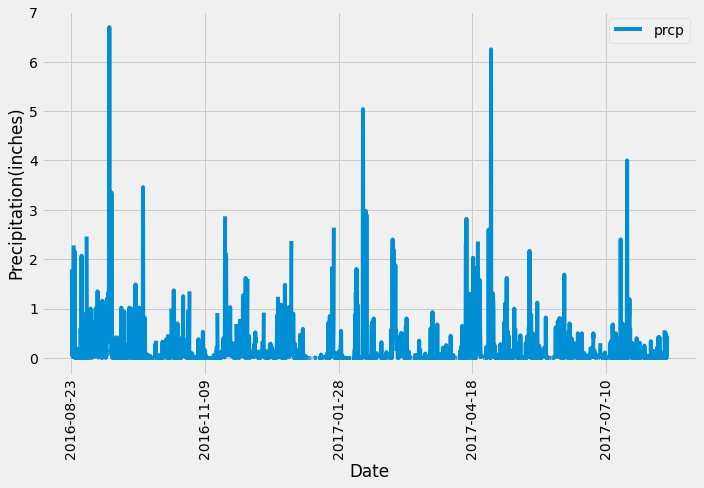

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
a_year_back=dt.date(2017,8,23)-dt.timedelta(days=365)
print(a_year_back)
# Perform a query to retrieve the data and precipitation scores

score_2016=session.query(measurement.date, measurement.prcp).filter(measurement.date>=a_year_back).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

score_2016_df=pd.DataFrame(score_2016)
# Sort the dataframe by date
score_2016_df=score_2016_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
score_2016_df.plot(x="date",y="prcp" ,rot=90,figsize=(10,7))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")

plt.tight_layout()
plt.show()

#name x/y  rotated label(rot=90)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
score_2016_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
sum_stations=session.query(station.station).count()
print(sum_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station=session.query(measurement.station,func.count(measurement.station))\
.group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
print(active_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostactive_station=session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs))\
.filter(measurement.station=="USC00519281").all()
print(mostactive_station)

[(54.0, 85.0, 71.66378066378067)]


<function matplotlib.pyplot.show(*args, **kw)>

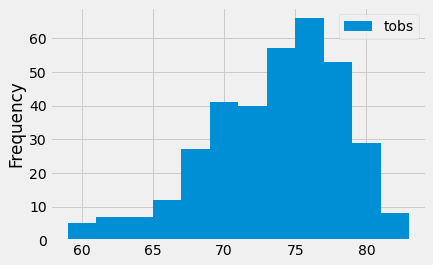

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostactive_station_2016=session.query(measurement.tobs).filter(measurement.station=="USC00519281")\
.filter(measurement.date>=a_year_back).all()
#print(mostactive_station_2016)

# score_2016_df=score_2016_df.sort_values("date")

# # Use Pandas Plotting with Matplotlib to plot the data
# score_2016_df.plot(x="date",y="prcp" ,rot=90)

# #name x/y  rotated label(rot=90)


mostactive_station_2016_df=pd.DataFrame(mostactive_station_2016)
mostactive_station_2016_df.plot.hist(bins=12)

# plt.tight_layout()
plt.show





# Close session

In [16]:
# Close Session
session.close()

 `/`

  * Home page.

  * List all routes that are available.

* `/api/v1.0/precipitation`

  * Convert the query results to a dictionary using `date` as the key and `prcp` as the value.

  * Return the JSON representation of your dictionary.

* `/api/v1.0/stations`

  * Return a JSON list of stations from the dataset.

* `/api/v1.0/tobs`
  * Query the dates and temperature observations of the most active station for the last year of data.

  * Return a JSON list of temperature observations (TOBS) for the previous year.

* `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

  * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

  * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

## Hints

* You will need to join the station and measurement tables for some of the queries.

* Use Flask `jsonify` to convert your API data into a valid JSON response object.


In [17]:
def calc_temps(start_date, end_date):
    c_results = session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
                    filter(measurement.date >= start_date).\
                    filter(measurement.date <= end_date).all()
    return c_results
calc_temps('2017-01-01', '2017-12-31')

[(58.0, 74.14387974230493, 87.0)]

In [18]:
trip_results = calc_temps('2017-07-02', '2017-07-08')
trip_results

[(71.0, 78.11904761904762, 87.0)]

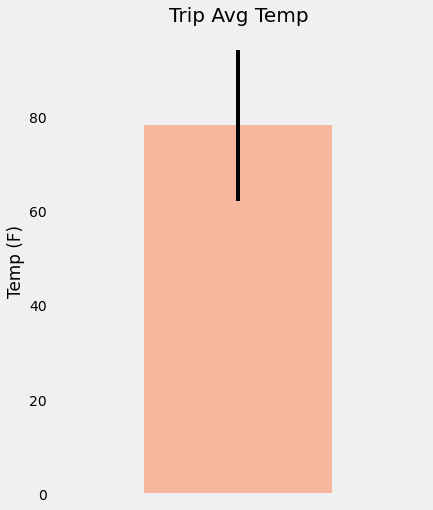

In [19]:
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
#plt.savefig("../TripTempSummary.png")
plt.show()

In [20]:
def daily_normals(day_date):
    temps = session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
                          filter(func.strftime("%m-%d", msmt.date) == day_date).all()
    return temps
    
#create a list of dates for your trip 
score_2016

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [21]:
trip_start = dt.date(2018,1,1)
trip_end = dt.date(2018,1,7)


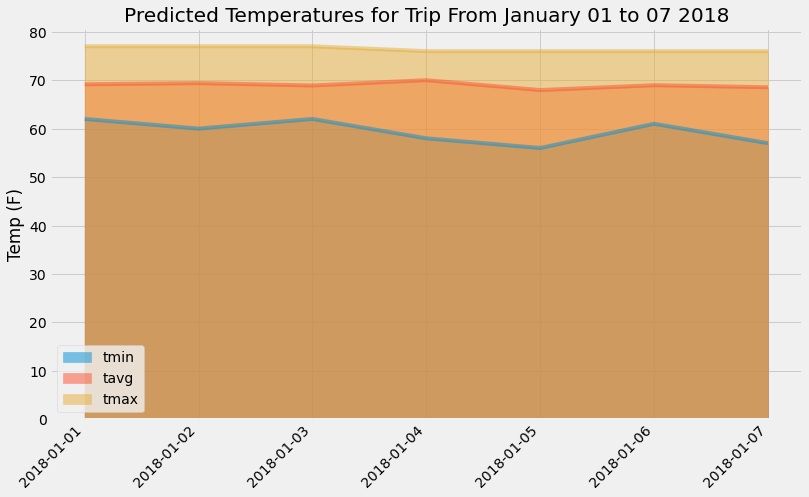

In [22]:
def daily_normals(day_date):
    temps = session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
                          filter(func.strftime("%m-%d", measurement.date) == day_date).all()
    return temps
    
#create a list of dates for your trip 
trip_dates = pd.date_range(trip_start, trip_end)

#format it to %m-%d
trip_mmdd = trip_dates.strftime('%m-%d')

#calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_mmdd:
    #unpack daily_normals
    normals_list.append(*daily_normals(trip_date))

#make a df
normals_df = pd.DataFrame(normals_list, columns = ['tmin', 'tavg', 'tmax'])

#make the trip dates the index
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

'''Area Plot'''

#make a colors list
#colors = ['blue', 'pink','white']

#make an area plot for the predicted temps
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, x_compat=True, 
                title='Predicted Temperatures for Trip From January 01 to 07 2018', rot=45)

#make the labels
plt.xlabel('')
plt.ylabel('Temp (F)')

plt.show()

In [23]:
session.close()